models here are those we tried to sue and weren't too successful, so they're here just in case

many of these imports will probably go unused but I still like getting them all out of the way imeeeediately

In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

import os



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from tqdm import tqdm


# set configurations
pd.set_option('display.max_columns', 100)
sns.set_style("white")

# keras imports
import tensorflow as tf
import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, SpatialDropout1D, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

# model imports
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import pickle
import joblib

reading in the training data from the datasets

In [2]:
trainDataframe = pd.read_csv('./data/train.csv')
testDataframe = pd.read_csv('./data/test.csv')

some data preprocessing before getting into the models. some of this was rolled over from data_processing and some of it is exclusive

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summerizedInfo = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summerizedInfo = summerizedInfo.reset_index()
    summerizedInfo['Name'] = summerizedInfo['index']
    summerizedInfo = summerizedInfo[['Name','dtypes']]
    summerizedInfo['Missing'] = df.isnull().sum().values    
    summerizedInfo['Uniques'] = df.nunique().values
    summerizedInfo['First Value'] = df.loc[0].values
    summerizedInfo['Second Value'] = df.loc[1].values
    summerizedInfo['Third Value'] = df.loc[2].values

    for name in summerizedInfo['Name'].value_counts().index:
        summerizedInfo.loc[summerizedInfo['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summerizedInfo

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    
    
    return df

it's very difficult to understand how to best analyze our data, so we made a graph to comprehend what we were looking at. 

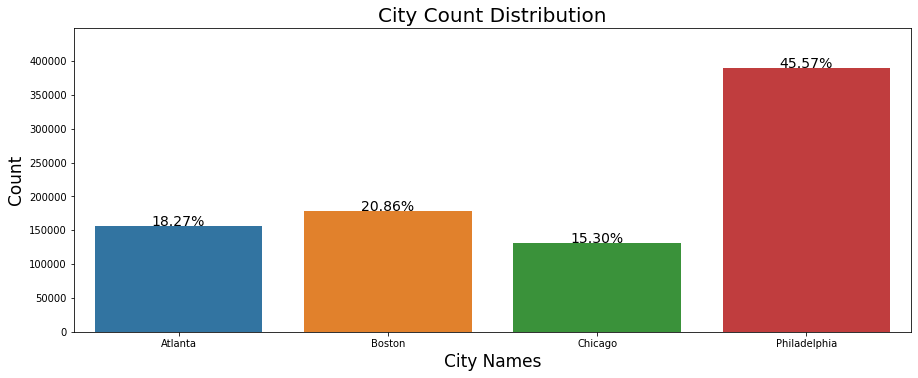

In [5]:
total = len(trainDataframe)
plt.figure(figsize=(15,19))

plt.subplot(311)
g = sns.countplot(x="City", data=trainDataframe)
g.set_title("City Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("City Names", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()


Atlanta seems best to use; it's around 150,000, which is decently usable without getting too excessive

In [6]:
tmp_hour = trainDataframe.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()

we also need to understand the timeline of what's going on and how this traffic is spread out along hours/days/weeks. 

models here are those we tried to sue and weren't too successful, so they're here just in case

many of these imports will probably go unused but I still like getting them all out of the way imeeeediately

In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

import os



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from tqdm import tqdm


# set configurations
pd.set_option('display.max_columns', 100)
sns.set_style("white")

# keras imports
import tensorflow as tf
import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, SpatialDropout1D, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

# model imports
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import pickle
import joblib

reading in the training data from the datasets

In [2]:
trainDataframe = pd.read_csv('./data/train.csv')
testDataframe = pd.read_csv('./data/test.csv')

some data preprocessing before getting into the models. some of this was rolled over from data_processing and some of it is exclusive

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summerizedInfo = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summerizedInfo = summerizedInfo.reset_index()
    summerizedInfo['Name'] = summerizedInfo['index']
    summerizedInfo = summerizedInfo[['Name','dtypes']]
    summerizedInfo['Missing'] = df.isnull().sum().values    
    summerizedInfo['Uniques'] = df.nunique().values
    summerizedInfo['First Value'] = df.loc[0].values
    summerizedInfo['Second Value'] = df.loc[1].values
    summerizedInfo['Third Value'] = df.loc[2].values

    for name in summerizedInfo['Name'].value_counts().index:
        summerizedInfo.loc[summerizedInfo['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summerizedInfo

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    
    
    return df

it's very difficult to understand how to best analyze our data, so we made a graph to comprehend what we were looking at. 

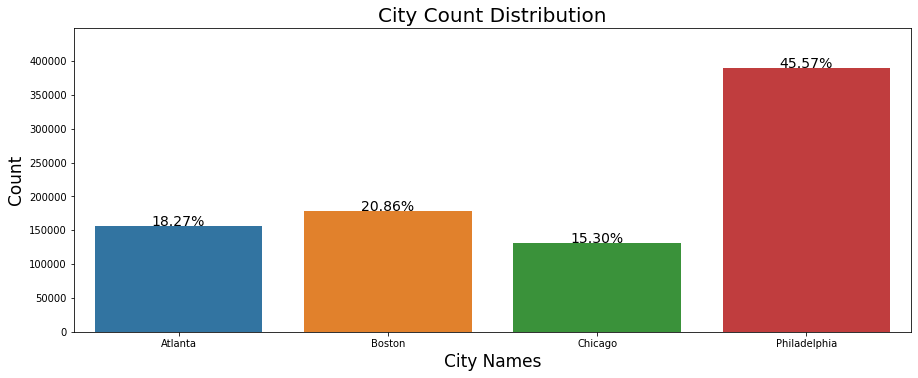

In [5]:
total = len(trainDataframe)
plt.figure(figsize=(15,19))

plt.subplot(311)
g = sns.countplot(x="City", data=trainDataframe)
g.set_title("City Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("City Names", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()


Atlanta seems best to use; it's around 150,000, which is decently usable without getting too excessive

In [6]:
tmp_hour = trainDataframe.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()

we also need to understand the timeline of what's going on and how this traffic is spread out along hours/days/weeks. 

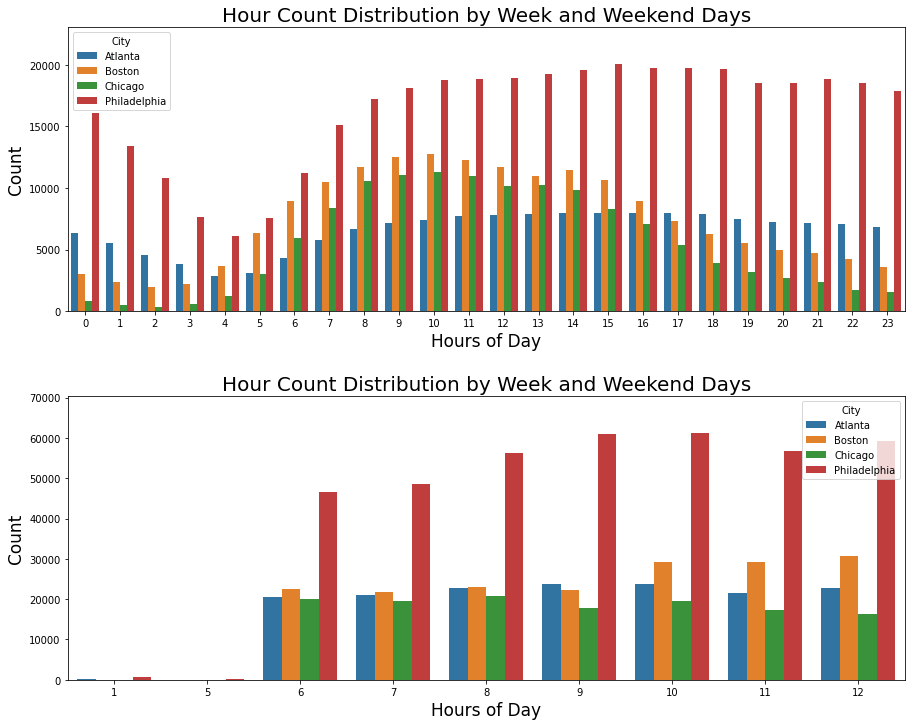

In [7]:
plt.figure(figsize=(15,12))

plt.subplot(211)
g = sns.countplot(x="Hour", data=trainDataframe, hue='City', dodge=True)
g.set_title("Hour Count Distribution by Week and Weekend Days", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Hours of Day", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="Month", data=trainDataframe, hue='City', dodge=True)
g1.set_title("Hour Count Distribution by Week and Weekend Days", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Hours of Day", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

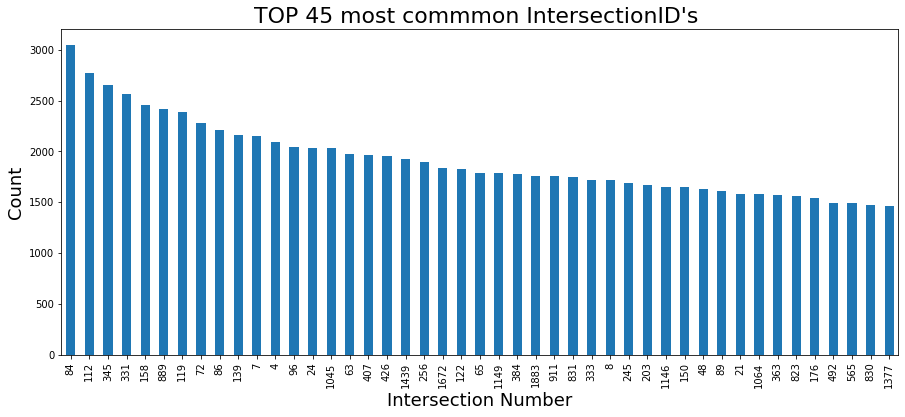

In [9]:
plt.figure(figsize=(15,6))
trainDataframe.IntersectionId.value_counts()[:45].plot(kind='bar')
plt.xlabel("Intersection Number", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("TOP 45 most commmon IntersectionID's ", fontsize=22)

plt.show()

In [10]:
trainDataframe.groupby(['IntersectionId', 'EntryHeading', 'ExitHeading'])['RowId'].count().reset_index().head()

,IntersectionId,EntryHeading,ExitHeading,RowId
0,0,E,E,128
1,0,E,N,23
2,0,E,NW,1
3,0,E,SW,3
4,0,N,E,34


In [11]:
t_stopped = ['TotalTimeStopped_p20',
             'TotalTimeStopped_p50', 
             'TotalTimeStopped_p80']
t_first_stopped = ['TimeFromFirstStop_p20',
                   'TimeFromFirstStop_p50',
                   'TimeFromFirstStop_p80']
d_first_stopped = ['DistanceToFirstStop_p20',
                   'DistanceToFirstStop_p50',
                   'DistanceToFirstStop_p80']

Scaling data to common scale; we can see they're really different, so we need a scale

In [13]:
from sklearn.preprocessing import minmax_scale

target_cols = t_stopped + d_first_stopped

In [14]:
for col in target_cols:
    trainDataframe[col+str("_minmax")] = (minmax_scale(trainDataframe[col], feature_range=(0,1)))
    
min_max_cols = ['TotalTimeStopped_p20_minmax', 'TotalTimeStopped_p50_minmax',
                'TotalTimeStopped_p80_minmax', 'DistanceToFirstStop_p20_minmax',
                'DistanceToFirstStop_p50_minmax', 'DistanceToFirstStop_p80_minmax']


first actual model with PCA is below and actually resulted in decent accuracy

In [15]:
pca = PCA(n_components=3, random_state=5)

principalComponents = pca.fit_transform(trainDataframe[min_max_cols])

principalDf = pd.DataFrame(principalComponents)

# df.drop(cols, axis=1, inplace=True)
prefix='Target_PCA'
principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

trainDataframe = pd.concat([trainDataframe, principalDf], axis=1)


good accuracy but reliability is questionable

In [16]:
pca.explained_variance_ratio_[:2].sum()

0.8388302642985757

k-means clustering may end up proving useful; since there are so many correlations that we don't know, unsupervised might be able to figure them out

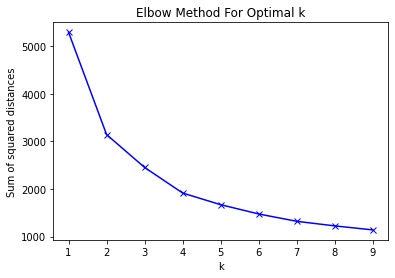

In [18]:
#sum of squared distances
ssd = []

K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=4)
    km = km.fit(trainDataframe[min_max_cols])
    ssd.append(km.inertia_)
    
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')

plt.show()

In [19]:
km = KMeans(n_clusters=4, random_state=4)
km = km.fit(trainDataframe[min_max_cols])
trainDataframe['clusters_T'] = km.predict(trainDataframe[min_max_cols])

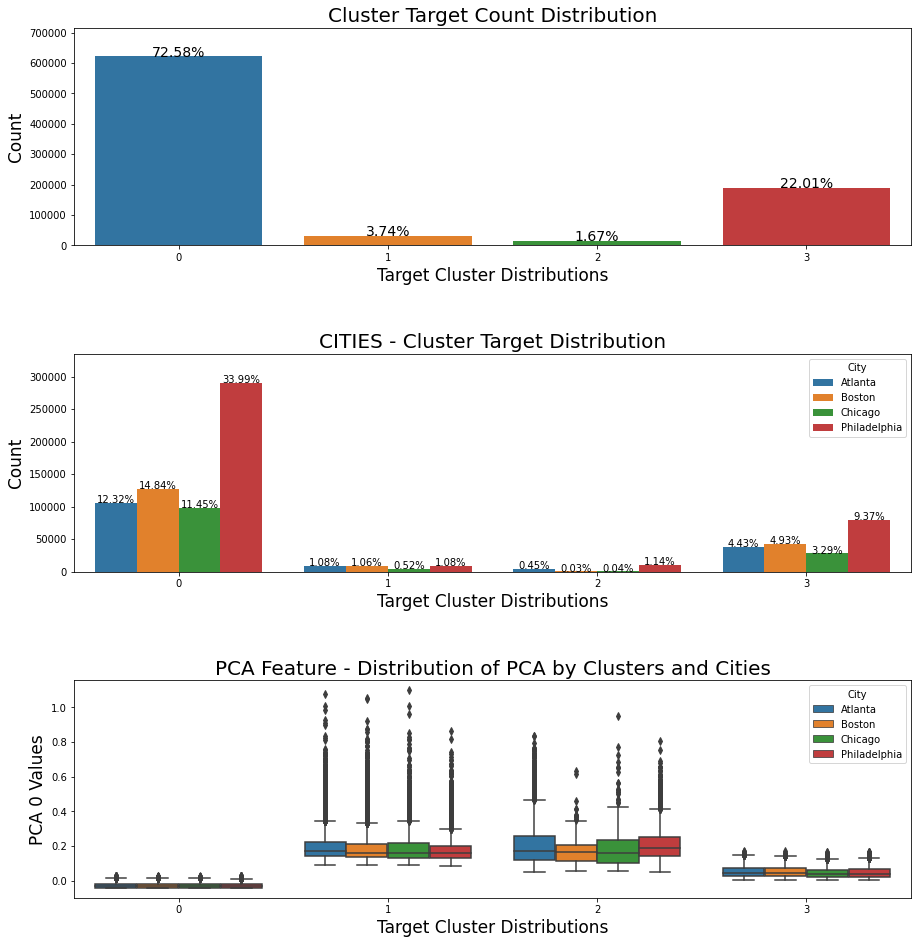

In [20]:
tmp = pd.crosstab(trainDataframe['City'], trainDataframe['clusters_T'], 
                  normalize='columns').unstack('City').reset_index().rename(columns={0:"perc"})

total = len(trainDataframe)
plt.figure(figsize=(15,16))

plt.subplot(311)
g = sns.countplot(x="clusters_T", data=trainDataframe)
g.set_title("Cluster Target Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(312)
g1 = sns.countplot(x="clusters_T", data=trainDataframe, hue='City')
g1.set_title("CITIES - Cluster Target Distribution", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10)
g1.set_ylim(0, max(sizes) * 1.15)

round(pd.crosstab([trainDataframe['clusters_T'], trainDataframe['Weekend']], trainDataframe['City'],
            normalize='index' ) * 100,0)

^K-means actually didn't turn out too bad, but there are obviously some problems to resolve

here, we're isolating and determining the hour and day parts of the dataset. note: from here on, the models aren't too great, they're notes and experiments by us

In [25]:
def date_cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    return df

trainDataframe = date_cyc_enc(trainDataframe, 'Hour', 24)
testDataframe = date_cyc_enc(testDataframe, 'Hour', 24) 

In [26]:
trainDataframe['is_day'] = trainDataframe['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)
testDataframe['is_day'] = testDataframe['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)

trainDataframe['is_morning'] = trainDataframe['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)
testDataframe['is_morning'] = testDataframe['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)

trainDataframe['is_night'] = trainDataframe['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)
testDataframe['is_night'] = testDataframe['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)

trainDataframe['is_day_weekend'] = np.where((trainDataframe['is_day'] == 1) & (trainDataframe['Weekend'] == 1), 1,0)
testDataframe['is_day_weekend'] = np.where((testDataframe['is_day'] == 1) & (trainDataframe['Weekend'] == 1), 1,0)

trainDataframe['is_mor_weekend'] = np.where((trainDataframe['is_morning'] == 1) & (trainDataframe['Weekend'] == 1), 1,0)
testDataframe['is_mor_weekend'] = np.where((testDataframe['is_morning'] == 1) & (trainDataframe['Weekend'] == 1), 1,0)

trainDataframe['is_nig_weekend'] = np.where((trainDataframe['is_night'] == 1) & (trainDataframe['Weekend'] == 1), 1,0)
testDataframe['is_nig_weekend'] = np.where((testDataframe['is_night'] == 1) & (trainDataframe['Weekend'] == 1), 1,0)
 

In [27]:
trainDataframe["Intersec"] = trainDataframe["IntersectionId"].astype(str) + trainDataframe["City"]
testDataframe["Intersec"] = testDataframe["IntersectionId"].astype(str) + testDataframe["City"]

print(trainDataframe["Intersec"].sample(6).values)

['93Atlanta' '158Atlanta' '1495Chicago' '497Atlanta' '717Philadelphia'
 '106Philadelphia']


In [28]:
le = LabelEncoder()

le.fit(pd.concat([trainDataframe["Intersec"],testDataframe["Intersec"]]).drop_duplicates().values)
trainDataframe["Intersec"] = le.transform(trainDataframe["Intersec"])
testDataframe["Intersec"] = le.transform(testDataframe["Intersec"])

In [29]:
road_encoding = {
    'Road': 1,
    'Street': 2,
    'Avenue': 2,
    'Drive': 3,
    'Broad': 3,
    'Boulevard': 4
}

In [30]:
def encode(x):
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
    return 0

In [31]:
trainDataframe['EntryType'] = trainDataframe['EntryStreetName'].apply(encode)
trainDataframe['ExitType'] = trainDataframe['ExitStreetName'].apply(encode)


another thing copied from data_processing

In [32]:
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

In [33]:
trainDataframe['EntryHeading'] = trainDataframe['EntryHeading'].map(directions)
trainDataframe['ExitHeading'] = trainDataframe['ExitHeading'].map(directions)

testDataframe['EntryHeading'] = testDataframe['EntryHeading'].map(directions)
testDataframe['ExitHeading'] = testDataframe['ExitHeading'].map(directions)

In [34]:
trainDataframe['diffHeading'] = trainDataframe['EntryHeading']-trainDataframe['ExitHeading']  
testDataframe['diffHeading'] = testDataframe['EntryHeading']-testDataframe['ExitHeading']

In [35]:
trainDataframe["same_str"] = (trainDataframe["EntryStreetName"] ==  trainDataframe["ExitStreetName"]).astype(int)
testDataframe["same_str"] = (testDataframe["EntryStreetName"] ==  testDataframe["ExitStreetName"]).astype(int)

In [36]:
# Concatenating the city and month into one variable
trainDataframe['city_month'] = trainDataframe["City"] + trainDataframe["Month"].astype(str)
testDataframe['city_month'] = testDataframe["City"] + testDataframe["Month"].astype(str)


In [37]:
monthly_rainfall = {'Atlanta1': 5.02, 'Atlanta5': 3.95, 'Atlanta6': 3.63, 'Atlanta7': 5.12, 
                    'Atlanta8': 3.67, 'Atlanta9': 4.09,'Atlanta10': 3.11, 'Atlanta11': 4.10, 
                    'Atlanta12': 3.82, 'Boston1': 3.92, 'Boston5': 3.24, 'Boston6': 3.22,
                    'Boston7': 3.06, 'Boston8': 3.37, 'Boston9': 3.47, 'Boston10': 3.79,
                    'Boston11': 3.98, 'Boston12': 3.73, 'Chicago1': 1.75, 'Chicago5': 3.38,
                    'Chicago6': 3.63, 'Chicago7': 3.51, 'Chicago8': 4.62, 'Chicago9': 3.27,
                    'Chicago10': 2.71,  'Chicago11': 3.01, 'Chicago12': 2.43, 
                    'Philadelphia1': 3.52, 'Philadelphia5': 3.88, 'Philadelphia6': 3.29,
                    'Philadelphia7': 4.39, 'Philadelphia8': 3.82, 'Philadelphia9':3.88 ,
                    'Philadelphia10': 2.75, 'Philadelphia11': 3.16, 'Philadelphia12': 3.31}

# Creating a new column by mapping the city_month variable to it's corresponding average monthly rainfall
trainDataframe["average_rainfall"] = trainDataframe['city_month'].map(monthly_rainfall)
testDataframe["average_rainfall"] = testDataframe['city_month'].map(monthly_rainfall)

In [38]:
print(f'Shape before dummy transformation: {trainDataframe.shape}')
trainDataframe = pd.get_dummies(trainDataframe, columns=['City' ],\
                          prefix=['City'], drop_first=False)

print(f'Shape after dummy transformation: {trainDataframe.shape}')

testDataframe = pd.get_dummies(testDataframe, columns=['City' ],\
                          prefix=['City'], drop_first=False)


Shape before dummy transformation: (856387, 53)
Shape after dummy transformation: (856387, 56)


In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in ['Latitude','Longitude']:
    scaler.fit(trainDataframe[col].values.reshape(-1, 1))
    trainDataframe[col] = scaler.transform(trainDataframe[col].values.reshape(-1, 1))
    testDataframe[col] = scaler.transform(testDataframe[col].values.reshape(-1, 1))

dropping these columns that turned out not useful

In [40]:
trainDataframe.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'
              ],axis=1, inplace=True)
testDataframe.drop(['RowId', 'Path',
              'EntryStreetName','ExitStreetName'],axis=1, inplace=True)

In [41]:
interesting_feat = ['IntersectionId', 'Latitude', 'Longitude', 'EntryHeading',
                    'ExitHeading', 'Hour', 'Weekend', 'Month',
                    'is_morning', 'is_night', 'is_day_weekend', 'is_mor_weekend',
                    'is_nig_weekend', #  'Hour_sin',
                    'Hour', 'same_str', 'Intersec', 'EntryType',
                    'ExitType', 'diffHeading', 'average_rainfall', 'is_day',
                    'City_Boston', 'City_Chicago', 'City_Philadelphia', 
                    'City_Atlanta']

total_time = ['TotalTimeStopped_p20',
              'TotalTimeStopped_p50', 
              'TotalTimeStopped_p80']

target_stopped = ['DistanceToFirstStop_p20',
                  'DistanceToFirstStop_p50',
                  'DistanceToFirstStop_p80']

In [42]:
X = trainDataframe[interesting_feat]
y = trainDataframe[total_time + target_stopped]

X_test = testDataframe[interesting_feat]

X.shape
X_test.shape
y.shape

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10,
                                                  random_state=42)

In [50]:
cat_feat = ['IntersectionId','Hour', 'Weekend','Month', 
            'is_day', 'is_morning', 'is_night', 
            'same_str', 'Intersec', 'City_Atlanta', 'City_Boston',
            'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType']

trying to use another sklearn model type to get a good accuracy. didn't turn out too successful, but led to using xg_boost which was eventually our end product

In [53]:
from sklearn.model_selection import KFold
import lightgbm as lgb

def evaluate_metric(params):
    
    all_preds_test ={0:[],1:[],2:[],3:[],4:[],5:[]}
    
    print(f'Params: {params}')
    FOLDS = 4    
    
    count=1
    
    for i in range(len(all_preds_test)):
        
        score_mean = 0
        
        kf = KFold(n_splits=FOLDS, shuffle=False, 
                   random_state=42)
        
       
        for tr_idx, val_idx in kf.split(X, y):
            
            X_tr, X_vl = X.iloc[tr_idx, :], X.iloc[val_idx, :]
            y_tr, y_vl = y.iloc[tr_idx], y.iloc[val_idx]

            lgtrain = lgb.Dataset(X_tr, label=y_tr.iloc[:,i])
            lgval = lgb.Dataset(X_vl, label=y_vl.iloc[:,i])

            lgbm_reg = lgb.train(params, lgtrain, 2000, valid_sets = [lgval],
                                 categorical_feature=cat_feat,
                                 verbose_eval=0, 
                                 early_stopping_rounds = 300)
                        
        pred_lgb = lgbm_reg.predict(X_val, num_iteration=lgbm_reg.best_iteration)
        all_preds_test[i] = pred_lgb
        score_uni = np.sqrt(mean_squared_error(pred_lgb, y_val.iloc[:,i]))
        print(f'Score Validation : {score_uni}')


    pred = pd.DataFrame(all_preds_test).stack()
    pred = pd.DataFrame(pred)
    
    y_val_sc = pd.DataFrame(y_val).stack()
    y_val_sc = pd.DataFrame(y_val_sc)    
    
    count = count +1
    
    score = np.sqrt(mean_squared_error(pred[0].values, y_val_sc[0].values ))
    #score = metric(df_val, pred)
    
    print(f'Full Score Run: {score}')
 
    return {
        'loss': score,
        'status': STATUS_OK
    }
